In [1]:
import torch as pt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

from dataset import RealSRV3

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
device = "cuda" if pt.cuda.is_available() else "cpu"
batch_size = 16
gen_lr = 1e-4
disc_lr = 1e-4
epochs = 30
low_stats = (0, 0, 0), (1, 1, 1)
high_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
dataset = RealSRV3("/mnt/d/Datasets/RealSR(V3)")
loader = DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=True)

In [4]:
def denorm(img_tensors, img_type="low"):
    if img_type == "low":
        return img_tensors * low_stats[1][0] + low_stats[0][0]
    else:
        return img_tensors * high_stats[1][0] + high_stats[0][0]

In [5]:
def show_images(images, n_max=batch_size):
    _, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach().cpu()[:n_max], img_type="high"), nrow=8).permute(1, 2, 0))

In [6]:
from generator import Generator
from discriminator import Discriminator

images.shape: torch.Size([16, 3, 24, 24])


/home/parth/miniconda3/envs/env-pytorch/lib/python3.8/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Generated Images shape: torch.Size([16, 3, 96, 96])


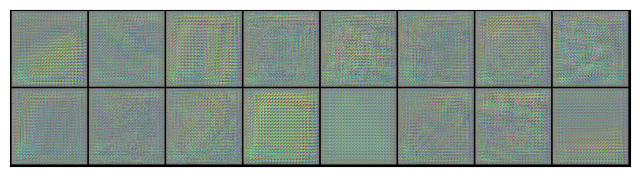

In [7]:
generator = Generator(upscale_factor=4).to(device)

for low_res_images, _ in loader:
    print(f"images.shape: {low_res_images.shape}")
    fake_images = generator(low_res_images.to(device))
    break
print(f"Generated Images shape: {fake_images.shape}")
show_images(fake_images)

In [8]:
discriminator = Discriminator(upscale_factor=4).to(device)

In [9]:
generator = generator.to(device).train()
discriminator = discriminator.to(device).train()

In [10]:
import os
import shutil
from tqdm import tqdm

In [11]:
sample_dir = "generated-images"
if os.path.exists(sample_dir):
    shutil.rmtree(sample_dir)
os.makedirs(sample_dir, exist_ok=True)

In [12]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator.eval()(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    # Save High Res Image
    save_image(
        denorm(fake_images.detach().cpu(), img_type="high"),
        os.path.join(sample_dir, fake_fname),
        nrow=8
    )
    print('Saving', fake_fname)
    fname = 'low-res-images-{0:0=4d}.png'.format(index)
    # Save Low Res Image
    save_image(
        denorm(latent_tensors.detach().cpu(), img_type="low"),
        os.path.join(sample_dir, fname),
        nrow=8
    )
    print('Saving', fname)
    if show:
        _, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.detach().cpu(), nrow=8).permute(1, 2, 0))
        plt.show()

In [13]:
from loss import GeneratorLoss

In [14]:
generator_loss = GeneratorLoss().to(device)

/home/parth/miniconda3/envs/env-pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/parth/miniconda3/envs/env-pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
def train_fn(idx, total_epochs, loader, disc, gen, opt_gen, opt_disc, gen_loss, bs):
    loader_bar = tqdm(loader)
    running_results = {
        "batch_sizes": 0, "d_loss": 0, "g_loss": 0, "d_score": 0, "g_score": 0
    }
    for low_res, high_res in loader_bar:
        running_results["batch_sizes"] += low_res.size(0)

        low_res = low_res.to(device)
        high_res = high_res.to(device)

        # Train Discriminator network
        # loss fn: Maximize: (D(high_res) - D(G(low_res)) + [1]) # (1 - D(high_res) + D(G(low_res)))
        # D(high_res) closer to 1 means able to detect high resolution images correctly
        # D(G(low_res)) closer to 0 means Generator is producing high resolution images and discriminator is able to detect it correctly
        fake = gen(low_res)

        opt_disc.zero_grad()
        disc_real_loss = disc(high_res).mean()
        disc_fake_loss = disc(fake).mean()
        d_loss = disc_real_loss - disc_fake_loss + 1
        d_loss.backward(retain_graph=True)
        opt_disc.step()

        # Update Generator network
        opt_gen.zero_grad()
        g_loss = gen_loss(disc_fake_loss, fake, high_res)
        g_loss.backward()
        opt_gen.step()

        running_results["g_loss"] += g_loss.item() * bs
        running_results["d_loss"] += d_loss.item() * bs
        running_results["d_score"] += disc_real_loss.item() * bs
        running_results["g_score"] += disc_fake_loss.item() * bs

        loader_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            idx+1, total_epochs, running_results['d_loss'] / running_results['batch_sizes'], 
            running_results['g_loss'] / running_results['batch_sizes'], 
            running_results['d_score'] / running_results['batch_sizes'], 
            running_results['g_score'] / running_results['batch_sizes']
        ))

    save_samples(idx+1, low_res, show=False)

    return running_results

In [17]:
opt_g = pt.optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.9, 0.999))
opt_d = pt.optim.Adam(discriminator.parameters(), lr=disc_lr, betas=(0.9, 0.999))

In [18]:
results = {
    "d_loss": [], "d_score": [],
    "g_loss": [], 'g_score': [],
}
for epoch in range(epochs):
    running_results = train_fn(epoch, epochs, loader, discriminator, generator,
                               opt_g, opt_d, generator_loss, batch_size)

    # Record losses & scores
    results["d_loss"].append(running_results["d_loss"] / running_results["batch_sizes"])
    results["g_loss"].append(running_results["g_loss"] / running_results["batch_sizes"])
    results["d_score"].append(running_results["d_score"] / running_results["batch_sizes"])
    results["g_score"].append(running_results["g_score"] / running_results["batch_sizes"])

[1/30] Loss_D: 0.1182 Loss_G: 0.0581 D(x): 0.0654 D(G(z)): 0.9491: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s]


Saving generated-images-0001.png
Saving low-res-images-0001.png


[2/30] Loss_D: 0.0475 Loss_G: 0.0231 D(x): 0.0291 D(G(z)): 0.9835: 100%|██████████| 196/196 [00:59<00:00,  3.29it/s]


Saving generated-images-0002.png
Saving low-res-images-0002.png


[3/30] Loss_D: 0.0496 Loss_G: 0.0190 D(x): 0.0183 D(G(z)): 0.9706: 100%|██████████| 196/196 [00:58<00:00,  3.36it/s]


Saving generated-images-0003.png
Saving low-res-images-0003.png


[4/30] Loss_D: 0.0190 Loss_G: 0.0170 D(x): 0.0066 D(G(z)): 0.9895: 100%|██████████| 196/196 [00:58<00:00,  3.37it/s]


Saving generated-images-0004.png
Saving low-res-images-0004.png


[5/30] Loss_D: 0.0173 Loss_G: 0.0159 D(x): 0.0089 D(G(z)): 0.9935: 100%|██████████| 196/196 [00:57<00:00,  3.40it/s]


Saving generated-images-0005.png
Saving low-res-images-0005.png


[6/30] Loss_D: 0.0134 Loss_G: 0.0152 D(x): 0.0094 D(G(z)): 0.9979: 100%|██████████| 196/196 [00:57<00:00,  3.43it/s]


Saving generated-images-0006.png
Saving low-res-images-0006.png


[7/30] Loss_D: 0.0108 Loss_G: 0.0145 D(x): 0.0034 D(G(z)): 0.9945: 100%|██████████| 196/196 [00:56<00:00,  3.46it/s]


Saving generated-images-0007.png
Saving low-res-images-0007.png


[8/30] Loss_D: 0.0090 Loss_G: 0.0141 D(x): 0.0051 D(G(z)): 0.9980: 100%|██████████| 196/196 [00:57<00:00,  3.40it/s]


Saving generated-images-0008.png
Saving low-res-images-0008.png


[9/30] Loss_D: 0.0194 Loss_G: 0.0137 D(x): 0.0070 D(G(z)): 0.9895: 100%|██████████| 196/196 [00:57<00:00,  3.43it/s]


Saving generated-images-0009.png
Saving low-res-images-0009.png


[10/30] Loss_D: 0.0310 Loss_G: 0.0133 D(x): 0.0125 D(G(z)): 0.9834: 100%|██████████| 196/196 [00:58<00:00,  3.35it/s]


Saving generated-images-0010.png
Saving low-res-images-0010.png


[11/30] Loss_D: 0.0258 Loss_G: 0.0130 D(x): 0.0184 D(G(z)): 0.9944: 100%|██████████| 196/196 [00:57<00:00,  3.40it/s]


Saving generated-images-0011.png
Saving low-res-images-0011.png


[12/30] Loss_D: 0.0260 Loss_G: 0.0129 D(x): 0.0152 D(G(z)): 0.9912: 100%|██████████| 196/196 [00:57<00:00,  3.42it/s]


Saving generated-images-0012.png
Saving low-res-images-0012.png


[13/30] Loss_D: 0.0080 Loss_G: 0.0124 D(x): 0.0006 D(G(z)): 0.9946: 100%|██████████| 196/196 [00:57<00:00,  3.40it/s]


Saving generated-images-0013.png
Saving low-res-images-0013.png


[14/30] Loss_D: 0.0165 Loss_G: 0.0124 D(x): 0.0071 D(G(z)): 0.9926: 100%|██████████| 196/196 [00:56<00:00,  3.45it/s]


Saving generated-images-0014.png
Saving low-res-images-0014.png


[15/30] Loss_D: 0.0205 Loss_G: 0.0123 D(x): 0.0064 D(G(z)): 0.9879: 100%|██████████| 196/196 [00:56<00:00,  3.44it/s]


Saving generated-images-0015.png
Saving low-res-images-0015.png


[16/30] Loss_D: 0.0032 Loss_G: 0.0120 D(x): 0.0010 D(G(z)): 0.9997: 100%|██████████| 196/196 [00:57<00:00,  3.42it/s]


Saving generated-images-0016.png
Saving low-res-images-0016.png


[17/30] Loss_D: 0.0448 Loss_G: 0.0135 D(x): 0.0347 D(G(z)): 0.9919: 100%|██████████| 196/196 [00:58<00:00,  3.34it/s]


Saving generated-images-0017.png
Saving low-res-images-0017.png


[18/30] Loss_D: 0.0068 Loss_G: 0.0119 D(x): 0.0012 D(G(z)): 0.9963: 100%|██████████| 196/196 [00:57<00:00,  3.39it/s]


Saving generated-images-0018.png
Saving low-res-images-0018.png


[19/30] Loss_D: 0.0010 Loss_G: 0.0117 D(x): 0.0000 D(G(z)): 1.0010: 100%|██████████| 196/196 [00:57<00:00,  3.40it/s]


Saving generated-images-0019.png
Saving low-res-images-0019.png


[20/30] Loss_D: 0.0083 Loss_G: 0.0116 D(x): 0.0065 D(G(z)): 1.0001: 100%|██████████| 196/196 [00:57<00:00,  3.42it/s]


Saving generated-images-0020.png
Saving low-res-images-0020.png


[21/30] Loss_D: 0.0064 Loss_G: 0.0116 D(x): 0.0032 D(G(z)): 0.9987: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Saving generated-images-0021.png
Saving low-res-images-0021.png


[22/30] Loss_D: 0.0259 Loss_G: 0.0117 D(x): 0.0146 D(G(z)): 0.9906: 100%|██████████| 196/196 [00:56<00:00,  3.46it/s]


Saving generated-images-0022.png
Saving low-res-images-0022.png


[23/30] Loss_D: 0.0035 Loss_G: 0.0115 D(x): 0.0022 D(G(z)): 1.0006: 100%|██████████| 196/196 [00:56<00:00,  3.45it/s]


Saving generated-images-0023.png
Saving low-res-images-0023.png


[24/30] Loss_D: 0.0833 Loss_G: 0.0128 D(x): 0.0313 D(G(z)): 0.9498: 100%|██████████| 196/196 [00:56<00:00,  3.49it/s]


Saving generated-images-0024.png
Saving low-res-images-0024.png


[25/30] Loss_D: 0.0312 Loss_G: 0.0114 D(x): 0.0096 D(G(z)): 0.9803: 100%|██████████| 196/196 [00:58<00:00,  3.35it/s]


Saving generated-images-0025.png
Saving low-res-images-0025.png


[26/30] Loss_D: 0.0526 Loss_G: 0.0118 D(x): 0.0193 D(G(z)): 0.9687: 100%|██████████| 196/196 [00:56<00:00,  3.45it/s]


Saving generated-images-0026.png
Saving low-res-images-0026.png


[27/30] Loss_D: 0.0217 Loss_G: 0.0114 D(x): 0.0125 D(G(z)): 0.9927: 100%|██████████| 196/196 [00:58<00:00,  3.33it/s]


Saving generated-images-0027.png
Saving low-res-images-0027.png


[28/30] Loss_D: 0.0095 Loss_G: 0.0109 D(x): 0.0066 D(G(z)): 0.9990: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


Saving generated-images-0028.png
Saving low-res-images-0028.png


[29/30] Loss_D: 0.0202 Loss_G: 0.0107 D(x): 0.0051 D(G(z)): 0.9869: 100%|██████████| 196/196 [00:57<00:00,  3.42it/s]


Saving generated-images-0029.png
Saving low-res-images-0029.png


[30/30] Loss_D: 0.0064 Loss_G: 0.0107 D(x): 0.0054 D(G(z)): 1.0009: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


Saving generated-images-0030.png
Saving low-res-images-0030.png


Text(0.5, 1.0, 'Discriminator Accuracy')

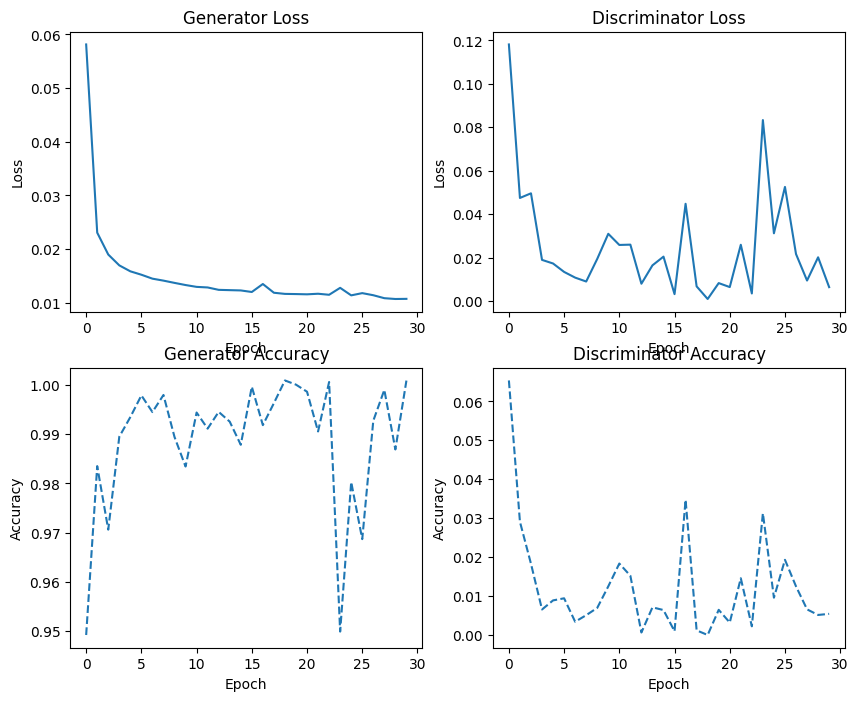

In [22]:
plt.figure(figsize=(10, 8), dpi=100)

plt.subplot(2, 2, 1)
plt.plot(results["g_loss"], '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')

plt.subplot(2, 2, 2)
plt.plot(results["d_loss"], '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')

plt.subplot(2, 2, 3)
plt.plot(results["g_score"], '--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Generator Accuracy')

plt.subplot(2, 2, 4)
plt.plot(results["d_score"], '--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')

In [20]:
if os.path.exists("models"):
    shutil.rmtree("models")
os.makedirs("models")

pt.save(generator.state_dict(), "models/generator-model")
pt.save(discriminator.state_dict(), "models/discriminator-model")